# **Deep Learning for Bitcoin price prediction**

![crypto image](https://images.unsplash.com/photo-1516245834210-c4c142787335?crop=entropy&cs=tinysrgb&fm=jpg&ixlib=rb-1.2.1&q=80&raw_url=true&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=869)

### **Objective**

- Built & Train a Deep model (RNN-GRU) to forecast the Bitcoin prices.

Author: Luis Fernando Salazar S.
Date: 23/05/2022

In [ ]:
!pip install yfinance

In [ ]:
# Import libraries
import os 
import pickle
import warnings
warnings.simplefilter(action = 'ignore')
from dateutil.relativedelta import relativedelta
import datetime
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, GRU, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Nadam, Adam

### **load and Explorate the dataset**

- Wrangle function 
- Overview information:
  -  Dataframe Structure
  -  Dimensionality
- Summary statistical
- Plot of raw data and their distributions
- Bitcoin Close Price in the last 40 days
- Autocorrelation Charts

#### **Wrangle function and Overview information of the dataset**

In [ ]:
def wrangle(ticker):
    
    # Start and final date
    Start = "2018-01-01"
    Today = date.today().strftime("%Y-%m-%d")
    
    #Download the bitcoin data with yfinance api
    df = yf.download(ticker, Start, Today)
    
    # Drop unnesar
    list_un = [
        'Open', 'High', 'Low',
        'Adj Close', 'Volume'
    ]
    
    df.drop(columns = list_un, inplace= True)
    
    return df    

In [ ]:
df = wrangle('BTC-USD')
df.info() 

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1608 entries, 2018-01-01 to 2022-05-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1608 non-null   float64
dtypes: float64(1)
memory usage: 25.1 KB


In [ ]:
df.head()

,Close
Date,
2018-01-01,13657.200195
2018-01-02,14982.099609
2018-01-03,15201.000000
2018-01-04,15599.200195
2018-01-05,17429.500000


In [ ]:
print(f"Dimension of the dataset: {df.shape}")

Dimension of the dataset: (1608, 1)


#### **Summary statistical**

In [ ]:
df.describe()

,Close
count,1608.000000
mean,20315.585551
std,18057.573574
min,3236.761719
25%,7321.751221
50%,10012.358398
75%,37091.019531
max,67566.828125


#### **Plot of raw data and their distributions**

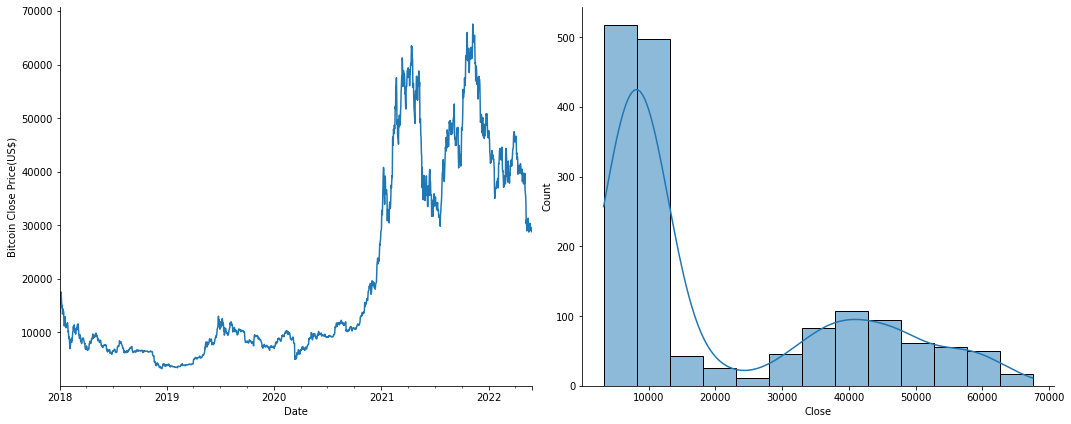

In [ ]:
## plot of raw data and their distributions

plt.figure(figsize =(15,6))
layout = (1, 2)

raw = plt.subplot2grid(layout,(0,0))
dist = plt.subplot2grid(layout,(0,1))

df['Close'].plot(kind = 'line',
        ylabel = 'Bitcoin Close Price(US$)',
        label = False,
        ax = raw)
sns.histplot(data = df, x ='Close', kde = True, ax = dist)
sns.despine()
plt.tight_layout();

#### **Bitcoin Close Price in the last 40 days**

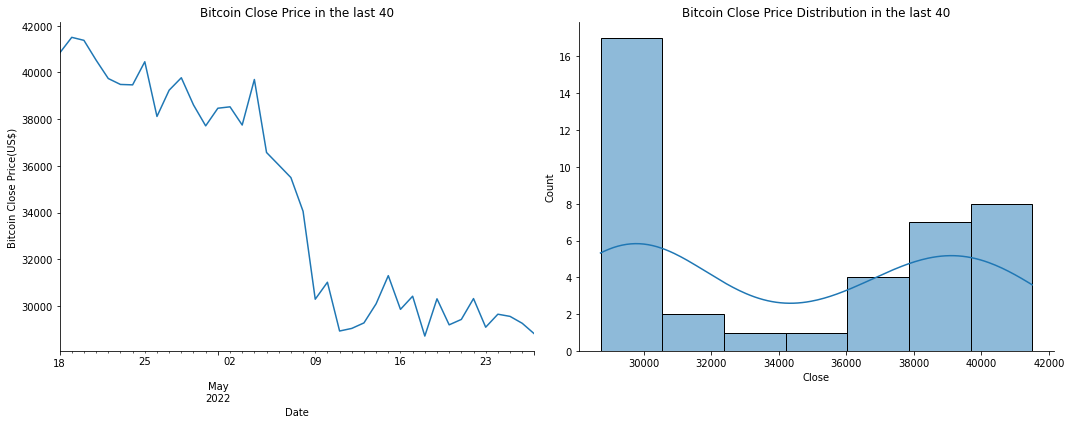

In [ ]:
plt.figure(figsize =(15,6))
layout = (1, 2)

# Past Days 
n_days = 40

raw_ = plt.subplot2grid(layout,(0,0))
dist_ = plt.subplot2grid(layout,(0,1))

df['Close'][-n_days:].plot(kind = 'line',
                          ylabel = 'Bitcoin Close Price(US$)',
                          title = f"Bitcoin Close Price in the last {n_days}",
                          ax = raw_)

sns.histplot(data = df, x =df['Close'][-n_days:], kde = True, ax = dist_)
dist_.set_title(f'Bitcoin Close Price Distribution in the last {n_days}')
sns.despine()
plt.tight_layout();

#### **Autocorrelation Charts**
- Autocorrelation Function
- Partial Autocorrelaction Function

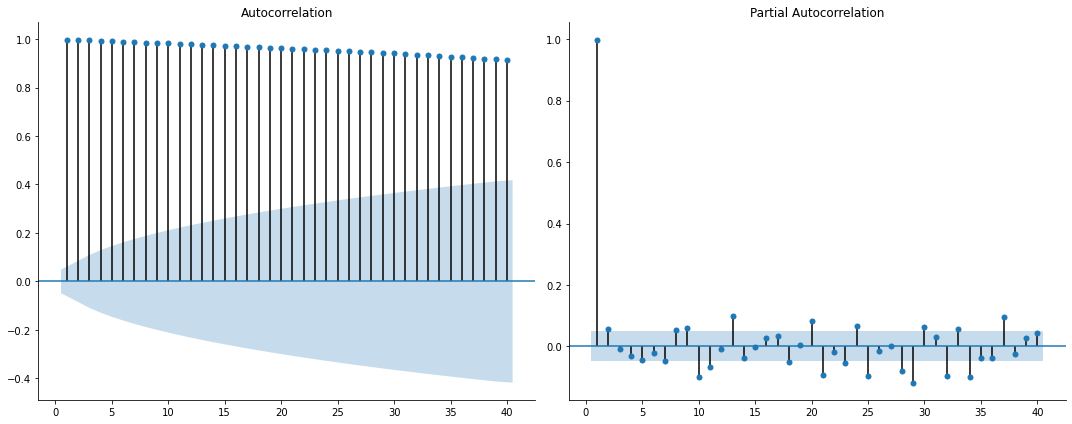

In [ ]:
## Autocorrelactions
plt.figure(figsize =(15,6))
layout = (1, 2)

# LAGS 
lags = 40
acf = plt.subplot2grid(layout,(0,0))
pacf = plt.subplot2grid(layout,(0,1))

plot_acf(df["Close"], lags = lags, ax = acf, zero = False) 
plot_pacf(df["Close"], lags = lags, ax = pacf, zero = False)

sns.despine()
plt.tight_layout();

### **Data Preprocessing**
- Scaling the data (MinMaxScaler)
- Split the dataset into train, val and test set

In [ ]:
mm = MinMaxScaler(feature_range = (0,1))
df_trans = mm.fit_transform(np.array(df)).reshape(-1,1) 

In [ ]:
## Train test split funtions
def train_test_split(n_days, split_1, split_2, sample_gap =3):
    
    f_series = df_trans
    
    # train and test set
    train_set = f_series[ :split_1]
    val_set = f_series[split_1:split_2]
    test_set = f_series[split_2: ]
    
    # X_train and y_train
    X_train, y_train = [],[]
    for i in range(0, train_set.shape[0]-n_days, sample_gap):
                     X_train.append(train_set[i: i+n_days])
                     y_train.append(train_set[i])
                     
    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    y_train = np.array(y_train)
    
    ## X_val and y_val
    X_val , y_val = [],[]
    
    for i in range(0, val_set.shape[0]-n_days):
        X_val.append(val_set[i:i+n_days])
        y_val.append(val_set[i])
        
    X_val = np.array(X_val)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)
    y_val = np.array(y_val)
    
    # X_test and y_test
    X_test, y_test = [],[]
    for i in range(0, test_set.shape[0]-n_days):
                     X_test.append(test_set[i: i+n_days])
                     y_test.append(test_set[i])
                     
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    y_test = np.array(y_test)
    
    
    return X_train, X_val, X_test,y_train, y_val, y_test

In [ ]:
##Splits
split_1 = round(len(df)*.8)
split_2 = round(len(df)*.9)

X_train, X_val, X_test,y_train, y_val, y_test = train_test_split(n_days, split_1, split_2)

In [ ]:
## Training and test data dimension
print('Training input shape: {}'.format(X_train.shape))
print('Training output shape: {}'.format(y_train.shape))
print('Validation input shape: {}'.format(X_val.shape))
print('Validation output shape: {}'.format(y_val.shape))
print('Test input shape: {}'.format(X_test.shape))
print('Test output shape: {}'.format(y_test.shape))

Training input shape: (416, 40, 1)
Training output shape: (416, 1)
Validation input shape: (121, 40, 1)
Validation output shape: (121, 1)
Test input shape: (121, 40, 1)
Test output shape: (121, 1)


In [ ]:
## Preparate the data to chart the outputs
df_train = df[:split_1+n_days]
df_val = df[split_1:split_2]
df_test = df[split_2:-n_days]

### **Modeling**
- Baseline model

- Distributed Training Strategy
  - Simple MirrorStrategy
- GRU model
  - Batch Size = 128
  - Epochs = 300
  - Nadam optimizer with a 0.001 base learning rate

- Trainin and validation plot
- Forecasting
 - Plot true vs predict
- Perfomarnce evaluation
 - Metrics:
  Mean Square Error

#### **Baseline model**

In [ ]:
## Base-line metric 
baseline = Sequential(
    [
      tf.keras.layers.Flatten(input_shape = (X_train.shape[1], 1)),
      Dense(1)
    ]


)
baseline.compile(optimizer = 'adam',loss = 'mse')

baseline.fit(X_train, y_train,
            steps_per_epoch = len(X_train)//32,
            batch_size = 32,
            epochs = 20,
            validation_data = (X_val, y_val),
            validation_steps = len(X_val)//32)

Epoch 1/20
13/13 [==============================] - 1s 13ms/step - loss: 0.3043 - val_loss: 1.4082
Epoch 2/20
13/13 [==============================] - 0s 5ms/step - loss: 0.1820 - val_loss: 0.7265
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0965 - val_loss: 0.3342
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.1392
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0258 - val_loss: 0.0483
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0146 - val_loss: 0.0245
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.0224
Epoch 8/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0247
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0093 - val_loss: 0.0264
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0091 - val_loss: 0.0268
Epoch 11/20
13/13 

#### **Distribute training strategy**

In [ ]:
## MirrorStrategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


#### **GRU model**

In [ ]:
def gru_model(units):
    
    inp = Input(shape=(X_train.shape[1],1))
    
    #conv1d = Conv1D(filters = filters, kernel_size = (5), 
                    #strides = 1, padding = 'causal', kernel_initializer= 'he_normal',
                    #activation = 'relu')(inp)
    #x = BatchNormalization()(conv1d)
    x = GRU(units = units, return_sequences = True, 
             kernel_initializer ="he_normal")(inp)
    x = BatchNormalization()(x)
    x = GRU(units = units, return_sequences = True, 
             kernel_initializer ="he_normal")(x)
    x = BatchNormalization()(x)
    x = GRU(units = units, return_sequences = True, 
             kernel_initializer ="he_normal")(x)
    x = BatchNormalization()(x)
    x = GRU(units = units, return_sequences = False, 
             kernel_initializer ="he_normal")(x)
    x = BatchNormalization()(x)
    x = Dense(units = units, activation = 'relu',kernel_initializer ="he_normal")(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    
    # Model
    model = Model(inputs = inp, outputs = output)
    
    ## Summary
    model.summary()
    
    ## Compile
    model.compile(optimizer = Nadam(learning_rate =0.0001), loss = 'mae')
    
    return model

In [ ]:
## Scope strategy
with strategy.scope():
    model = gru_model(units = 250)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
# Callbacks
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, mode='min')

In [ ]:
## batch size and epochs
epochs = 5000
batch_size_per_replica = 64
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync

In [ ]:
## Fit the model
hist = model.fit(X_train, y_train,
                #steps_per_epoch = len(X_train)//batch_size,
                epochs = epochs,
                batch_size = batch_size,
                validation_data = (X_val, y_val),
                #validation_steps = len(X_val)//batch_size,
                verbose = 0,
                callbacks = [lr_reduce])

val loss:0.012662342749536037


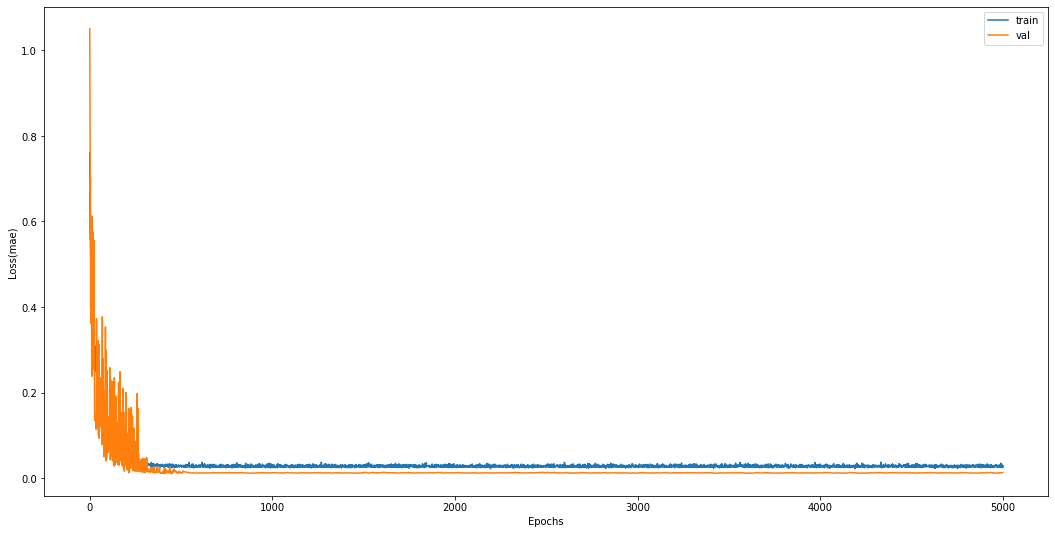

In [ ]:
## Model performance with the train and validations set
plt.figure(figsize=(18,9))
plt.plot(hist.history['loss'], label ='train')
plt.plot(hist.history['val_loss'], label ='val')
plt.xlabel('Epochs')
plt.ylabel('Loss(mae)')
plt.legend(loc ='upper right');

# ----------------- Model evaluation with validation set----------
model_eva = model.evaluate(X_val, y_val, verbose =0)
print(f"val loss:{model_eva}")

#### **Forecasting**

In [ ]:
y_pre = model.predict(X_test)
y_pre_in = mm.inverse_transform(y_pre)

 root-mean-square error: 0.013544134400249356


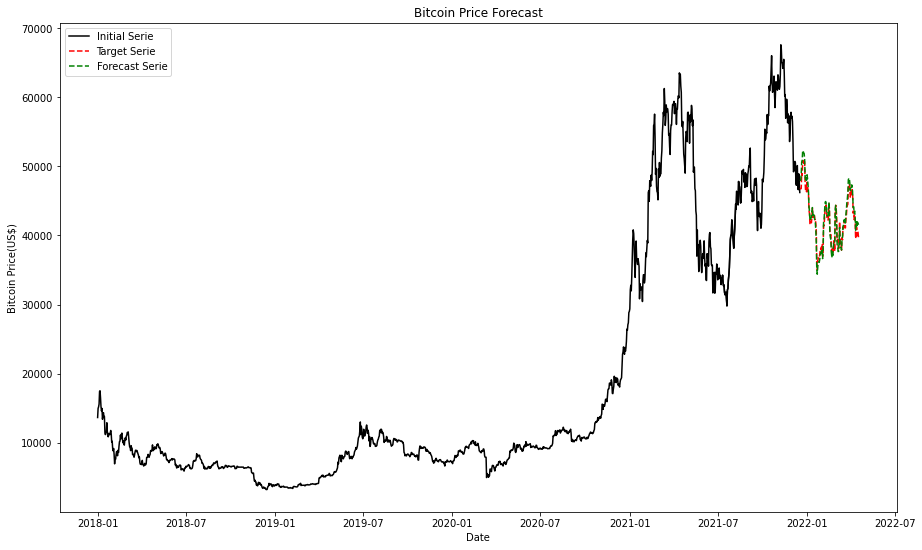

In [ ]:
from sklearn.metrics import mean_squared_error
## Plot true label vs predict label
plt.figure(figsize =(15, 9))
df_test['pred'] = y_pre_in
## Plot
plt.plot(df_train['Close'], color = 'black', label = 'Initial Serie')
plt.plot(df_val['Close'], color = 'black', label = None)
plt.plot(df_test['Close'], color = 'red', linestyle = '--', label = 'Target Serie')
plt.plot(df_test['pred'], color = 'green', linestyle = '--', label = 'Forecast Serie')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price(US$)')
plt.title('Bitcoin Price Forecast')
plt.legend(loc='upper left');

##------------------Root mean Square error-----------------
rmse = np.sqrt(mean_squared_error(y_test, y_pre))
print(f" root-mean-square error: {rmse}")

#### **Save the model**

In [ ]:
model.save('Bitcoin_model_v1', save_format = 'h5')